# Challenge: Build an NLP Model
For this challenge, we chose a corpus of data from nltk or another source that includes categories to predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk
import json
import requests
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

## Extract Shakespeare Works

In [3]:
# Load the data.
caesar = gutenberg.raw('shakespeare-caesar.txt')
hamlet = gutenberg.raw('shakespeare-hamlet.txt')
macbeth = gutenberg.raw('shakespeare-macbeth.txt')


In [4]:
#Remove idiosyncratic Act (Actus) and Scene (Scena) headers
caesar = re.sub(r'Actus .*', '', caesar)
hamlet = re.sub(r'Actus .*', '', hamlet)
macbeth = re.sub(r'Actus .*', '', macbeth)

## Text Cleaning

In [5]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
caesar_clean = text_cleaner(caesar)
hamlet_clean = text_cleaner(hamlet)
macbeth_clean = text_cleaner(macbeth)

## NLP via Spacy

In [6]:
nlp = spacy.load('en')

caesar_doc = nlp(caesar_clean)
hamlet_doc = nlp(hamlet_clean)
macbeth_doc = nlp(macbeth_clean)

## Sentence Extraction

In [12]:
# Group into sentences.
caesar_sents = [[sent, "Caesar"] for sent in caesar_doc.sents]
hamlet_sents = [[sent, "Hamlet"] for sent in hamlet_doc.sents]
macbeth_sents = [[sent, "Macbeth"] for sent in macbeth_doc.sents]

print(len(caesar_sents))
print(len(hamlet_sents))
print(len(macbeth_sents))

2330
3303
2128


In [13]:
#Trim datasets so that document lengths are the same
c_sents = caesar_sents[:len(macbeth_sents)]
h_sents = hamlet_sents[:len(macbeth_sents)]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(c_sents + h_sents + macbeth_sents)
sentences.head()

,0,1
0,"(Enter, Flauius, ,, Murellus, ,, and, certaine...",Caesar
1,"(Flauius, .)",Caesar
2,"(Hence, :, home, you, idle, Creatures, ,, get,...",Caesar
3,"(Is, this, a, Holiday, ?)",Caesar
4,"(What, ,, know, you, not, (, Being, Mechanical...",Caesar


## Create BoW Features

In [14]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%500 == 0:
            print('Processing row {}'.format(i))
    return df

In [150]:
#Reset docs with new set of sentences
new_caesar_doc = ' '.join([(str(sent)) for sent in pd.DataFrame(c_sents)[0]])
new_hamlet_doc = ' '.join([(str(sent)) for sent in pd.DataFrame(h_sents)[0]])

# Set up the bags.
caesarwords = bag_of_words(nlp(new_caesar_doc))
hamletwords = bag_of_words(nlp(new_hamlet_doc))
macbethwords = bag_of_words(macbeth_doc)

# Combine bags to create a set of unique words.
common_words = set(caesarwords + hamletwords + macbethwords)

In [19]:
# Create features
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000


,broad,orewhelm,sightlesse,chafe,Bear't,bonfire,Implements,bray,plunge,Byrnan,...,dis,body,smooth,grant,corporall,Holyday,friend,conceiue,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Enter, Flauius, ,, Murellus, ,, and, certaine...",Caesar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Flauius, .)",Caesar
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Hence, :, home, you, idle, Creatures, ,, get,...",Caesar
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Is, this, a, Holiday, ?)",Caesar
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(What, ,, know, you, not, (, Being, Mechanical...",Caesar


In [20]:
word_counts.shape

(6384, 4318)

## Create tf-idf Features

In [31]:
sents_list = [str(sent) for sent in sentences[0]]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(sents_list, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the sentences
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #Shakespeare tends to capitalize words for emphasis
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer sentences and shorter sentences get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
sents_tfidf=vectorizer.fit_transform(sents_list)
print("Number of features: %d" % sents_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(sents_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of sentences
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bysent[5])

Number of features: 3161
Original sentence: Be Lyon metled, proud, and take no care:
Tf_idf vector: {'metled': 0.49101402450721193, 'proud': 0.49101402450721193, 'care': 0.4429901765213423, 'Lyon': 0.45172725607865366, 'Be': 0.342801174291604}


## Unsupervised Learning: SVD Data Reduction

In [34]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 3161 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
sents_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(sents_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 38.150758120041104
Component 0:
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Ham.    0.966633
Name: 0, dtype: float64
Component 1:
my Lord, which was reported Macb.    0.862063
Macb.                                0.842634
Macb.                                0.842634
Macb.                                0.842634
Macb.                                0.842634
Macb.                                0.842634
' Building Macb.                     0.842634
Macb.                                0.842634
Macb.                                0.842634
Macb.                                0.842634
Name: 1, dtype: float64
Component 2:
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Enter.    0.949122
Name: 2, dtype: float64
Compo

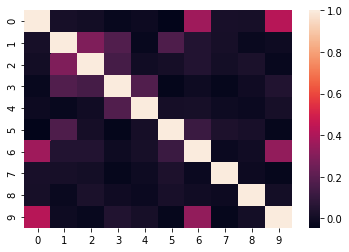

Key:
0 Not so my Lord, I am too much i'th' Sun Queen.
1 hew him as a Carkasse fit for Hounds: And let our Hearts, as subtle Masters do, Stirre vp their Seruants to an acte of Rage, And after seeme to chide 'em.
2 We ore-wrought on the way: of these we told him, And there did seeme in him a kinde of ioy
3 Another generall shout?
4 Giue me that man, That is not Passions Slaue, and I will weare him In my hearts Core.
5 Be Lyon metled, proud, and take no care:
6 At home, my Lord Ham.
7 Enter Portia.
8 All haile Macbeth, haile to thee Thane of Glamis 2.
9 Nay, good my Lord, this courtesie is not of the right breed.


In [35]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Supervised Learning: Random Forest, Logistic Regression, and Gradient Boosting Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9370757180156658

Test set score: 0.6468285043069695


In [43]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3830, 4316) (3830,)
Training set score: 0.891644908616188

Test set score: 0.677760375880971


In [44]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.6702349869451697

Test set score: 0.6221613155833986


Some of the issues with this version of the dataset is that, since we're dealing with Shakespeare plays, the names of the characters appear on new lines, which leads to skewed components with the SVD Reduction. By separating out chunks of text (or paragraphs) from each play, instead of sentences, we can possibly bypass that component grouping issue. Additionally, let's try including other features of each section of the text to see if we can improve the accuracy scores.

## Text Cleaning and Paragraph Separation

In [191]:
def par_clean(text):
    #Remove idiosyncratic Act and Scene Labels, as well as enter and exit directions.
    text = re.sub(r'Exeunt.*', '', text)
    text = re.sub(r'Enter.*', '', text)
    text = re.sub(r'Actus .*', '', text)
    text = re.sub(r'Scena .*', '', text)
    text = re.sub(r'Exit .*', '', text)
    
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    
    paras_list = [re.sub(r'^\w+\.', '', item.strip()).strip() for item in re.split(r"\n", text)]

    new_paras_list = []
    current_section = ''
    for i in range(len(paras_list)):
        if paras_list[i] == '':
            new_paras_list.append(current_section)
            current_section = ''
        else:
            current_section = current_section + ' ' + paras_list[i]

    return [item.strip() for item in new_paras_list if item != '']        
            

In [144]:
# Group into paragraphs.
caesar_paras = [[nlp(par), "Caesar"] for par in par_clean(caesar)]
hamlet_paras = [[nlp(par), "Hamlet"] for par in par_clean(hamlet)]
macbeth_paras = [[nlp(par), "Macbeth"] for par in par_clean(macbeth)]

print(len(caesar_paras))
print(len(hamlet_paras))
print(len(macbeth_paras))

697
899
590


In [145]:
#Trim datasets so that document lengths are the same
c_paras = caesar_paras[:len(macbeth_paras)]
h_paras = hamlet_paras[:len(macbeth_paras)]

# Combine the sentences from the two novels into one data frame.
paragraphs = pd.DataFrame(c_paras + h_paras + macbeth_paras)
paragraphs.head()

,0,1
0,"(Hence, :, home, you, idle, Creatures, ,, get,...",Caesar
1,"(Where, is, thy, Leather, Apron, ,, and, thy, ...",Caesar
2,"(But, what, Trade, art, thou, ?, Answer, me, d...",Caesar
3,"(A, Trade, Sir, ,, that, I, hope, I, may, vse,...",Caesar
4,"(What, Trade, thou, knaue, ?, Thou, naughty, k...",Caesar


In [151]:
#Reset docs with new set of sentences
paras_caesar_doc = ' '.join([(str(par)) for par in pd.DataFrame(c_paras)[0]])
paras_hamlet_doc = ' '.join([(str(par)) for par in pd.DataFrame(h_paras)[0]])
paras_macbeth_doc = ' '.join([(str(par)) for par in pd.DataFrame(macbeth_paras)[0]])

# Set up the bags.
caesarwords = bag_of_words(nlp(paras_caesar_doc))
hamletwords = bag_of_words(nlp(paras_hamlet_doc))
macbethwords = bag_of_words(nlp(paras_macbeth_doc))

# Combine bags to create a set of unique words.
new_common_words = set(caesarwords + hamletwords + macbethwords)

## Define New BoW Features

In [148]:
def par_bow_features(paragraphs, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_paragraph'] = paragraphs[0]
    df['text_source'] = paragraphs[1]
    df.loc[:,common_words] = 0
    
    for i, paragraph in enumerate(df['text_paragraph']):
        words = [token.lemma_ 
                for token in paragraph
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%500 == 0:
            print('Processing row {}'.format(i))
    return df

In [213]:
# Create features
new_word_counts = par_bow_features(paragraphs, new_common_words)
new_word_counts.head()

,broad,orewhelm,sightlesse,chafe,Bear't,bonfire,Implements,bray,plunge,Byrnan,...,dis,body,smooth,grant,corporall,Holyday,friend,conceiue,text_paragraph,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Hence, :, home, you, idle, Creatures, ,, get,...",Caesar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Where, is, thy, Leather, Apron, ,, and, thy, ...",Caesar
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(But, what, Trade, art, thou, ?, Answer, me, d...",Caesar
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(A, Trade, Sir, ,, that, I, hope, I, may, vse,...",Caesar
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(What, Trade, thou, knaue, ?, Thou, naughty, k...",Caesar


In [214]:
new_word_counts.shape

(1732, 4303)

## Create New tf-idf Features

In [220]:
paras_list = [str(par) for par in paragraphs[0]]

In [228]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(paras_list, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.7, # drop words that occur in more than half the sentences
                             min_df=4, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #Shakespeare tends to capitalize words for emphasis
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer sentences and shorter sentences get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
paras_tfidf=vectorizer.fit_transform(paras_list)
print("Number of features: %d" % paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1205
Original sentence: Could Beautie my Lord, haue better Comerce then your Honestie? I trulie: for the power of Beautie, will sooner transforme Honestie from what is, to a Bawd, then the force of Honestie can translate Beautie into his likenesse. This was sometime a Paradox, but now the time giues it I did loue you once
Tf_idf vector: {'sooner': 0.44059191427500544, 'force': 0.4189442453330255, 'power': 0.3514016687825042, 'better': 0.3191832077412201, 'giues': 0.3743491225867749, 'did': 0.2399918646941736, 'loue': 0.26221142329000285, 'lord': 0.1983084226321303, 'time': 0.256814726629944, 'haue': 0.18230525484808208}


## Unsupervised Learning - New Dataset

In [229]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1205 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    print('\n')

Percent variance captured by all components: 50.295730439107814
Component 0:
You are merrie, my Lord? Who I? I my Lord    0.902525
My Lord, I will not                          0.902525
I will my Lord                               0.902525
Not I my Lord                                0.902525
Propose the Oath my Lord                     0.902525
I will my Lord.                              0.902525
& Mar. within. My Lord, my Lord.             0.902525
I will, my Lord.                             0.902525
Nor I, my Lord                               0.902525
My Lord that would dishonour him             0.902525
Name: 0, dtype: float64


Component 1:
You are merrie, my Lord? Who I? I my Lord    0.380909
My Lord, I will not                          0.380909
I will, my Lord.                             0.380909
What is't my Lord? we will                   0.380909
My Lord                                      0.380909
I will my Lord                               0.380909
Nor I, my Lord      

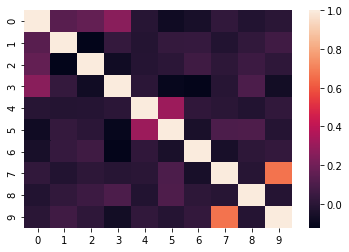

Key:
0 See where their basest mettle be not mou'd, They vanish tongue-tyed in their guiltinesse: Go you downe that way towards the Capitoll, This way will I: Disrobe the Images, If you do finde them deckt with Ceremonies
1 If it assume my noble Fathers person, Ile speake to it, though Hell it selfe should gape And bid me hold my peace. I pray you all, If you haue hitherto conceald this sight; Let it bee treble in your silence still: And whatsoeuer els shall hap to night, Giue it an vnderstanding but no tongue; I will requite your loues; so fare ye well: Vpon the Platforme twixt eleuen and twelue, Ile visit you
2 My young remembrance cannot paralell A fellow to it.
3 Drinkes
4 And what did you enact? I did enact Iulius Caesar, I was kill'd i'th' Capitol: Brutus kill'd me
5 Could Beautie my Lord, haue better Comerce then your Honestie? I trulie: for the power of Beautie, will sooner transforme Honestie from what is, to a Bawd, then the force of Honestie can translate Beautie into his lik

In [224]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Supervised Learning - New Dataset

In [231]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
Y = new_word_counts['text_source']
X = np.array(new_word_counts.drop(['text_paragraph','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.983638113570741

Test set score: 0.6118326118326118


In [232]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(1039, 4301) (1039,)
Training set score: 0.9547641963426372

Test set score: 0.6825396825396826


In [233]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.7757459095283927

Test set score: 0.6421356421356421


## Supervised Learning - w/ Added Features

In [243]:
new_word_counts['sent_length'] = new_word_counts['text_paragraph'].map(lambda x: len(x)) 
new_word_counts['num_verbs'] = [len([token.text.strip() for token in par if token.pos_=='VERB']) for par in paragraphs[0]]
new_word_counts['num_nouns'] = [len([token.text.strip() for token in par if token.pos_=='NOUN']) for par in paragraphs[0]]
new_word_counts['num_adverbs'] = [len([token.text.strip() for token in par if token.pos_=='ADV']) for par in paragraphs[0]]
new_word_counts['num_total_punct'] = [len([token.text.strip() for token in par if token.pos_ == 'PUNCT']) for par in paragraphs[0]]

In [275]:
rfc = RandomForestClassifier()
Y2 = new_word_counts['text_source']
X2 = np.array(new_word_counts.drop(['text_paragraph','text_source'], 1))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                    Y2,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train2, y_train2)

print('Training set score:', rfc.score(X_train2, y_train2))
print('\nTest set score:', rfc.score(X_test2, y_test2))

Training set score: 0.9913378248315688

Test set score: 0.6305916305916306


In [276]:
lr = LogisticRegression()
train = lr.fit(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print('Training set score:', lr.score(X_train2, y_train2))
print('\nTest set score:', lr.score(X_test2, y_test2))

(1039, 4306) (1039,)
Training set score: 0.960538979788258

Test set score: 0.6753246753246753


In [277]:
clf = GradientBoostingClassifier()
train = clf.fit(X_train2, y_train2)

print('Training set score:', clf.score(X_train2, y_train2))
print('\nTest set score:', clf.score(X_test2, y_test2))

Training set score: 0.8026948989412896

Test set score: 0.6406926406926406


Overall, we achieved a maximum testing accuracy score of 68.3%, which was accomplished using Logistic Regression on the word_count dataset created from the paragraphs compilation of the three Shakespearean works, without the additional features (nouns, verbs, adverbs, sentence length, etc) included. The highest level of variance represented by the set of components was also from the paragraph dataset, with approximately 50% of the total variance represented.